### Import Libraries 

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE


In [44]:
df = pd.read_csv('brain_stroke.csv')  
df.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [45]:
le = LabelEncoder()
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    df[col] = le.fit_transform(df[col])


In [46]:
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [47]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_bal))


Before SMOTE: [3786  198]
After SMOTE: [3786 3786]


In [48]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = []

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    results.append((name, acc, auc))

    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")


--- Logistic Regression ---
Accuracy: 0.7412236710130391
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.84       947
           1       0.14      0.80      0.24        50

    accuracy                           0.74       997
   macro avg       0.56      0.77      0.54       997
weighted avg       0.94      0.74      0.81       997

Confusion Matrix:
 [[699 248]
 [ 10  40]]


--- Naive Bayes ---
Accuracy: 0.7311935807422267
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.73      0.84       947
           1       0.12      0.72      0.21        50

    accuracy                           0.73       997
   macro avg       0.55      0.73      0.52       997
weighted avg       0.94      0.73      0.81       997

Confusion Matrix:
 [[693 254]
 [ 14  36]]


--- SVM ---
Accuracy: 0.7753259779338014
Classification Report:
               precision    recall  f1-s

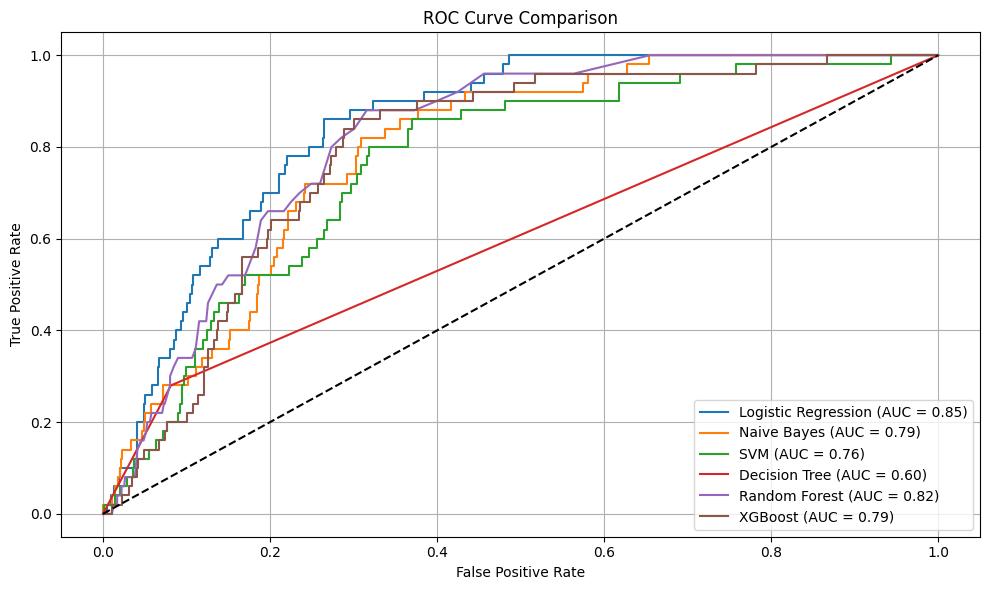

In [49]:
plt.figure(figsize=(10, 6))
for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


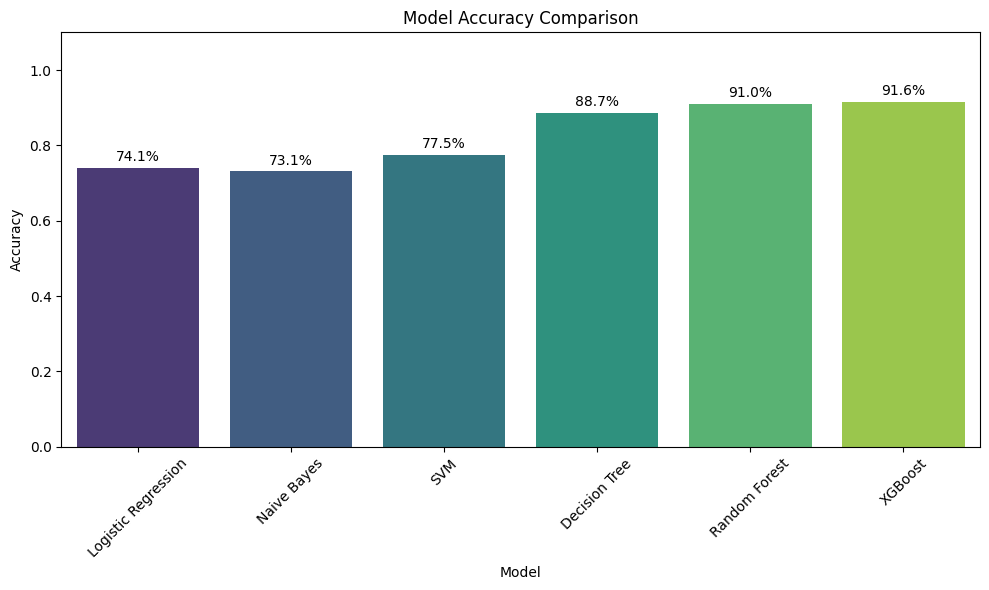

In [50]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'AUC'])

plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')

for i, bar in enumerate(barplot.patches):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,   
        height + 0.01,                       
        f'{height*100:.1f}%',                
        ha='center', va='bottom', fontsize=10
    )

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

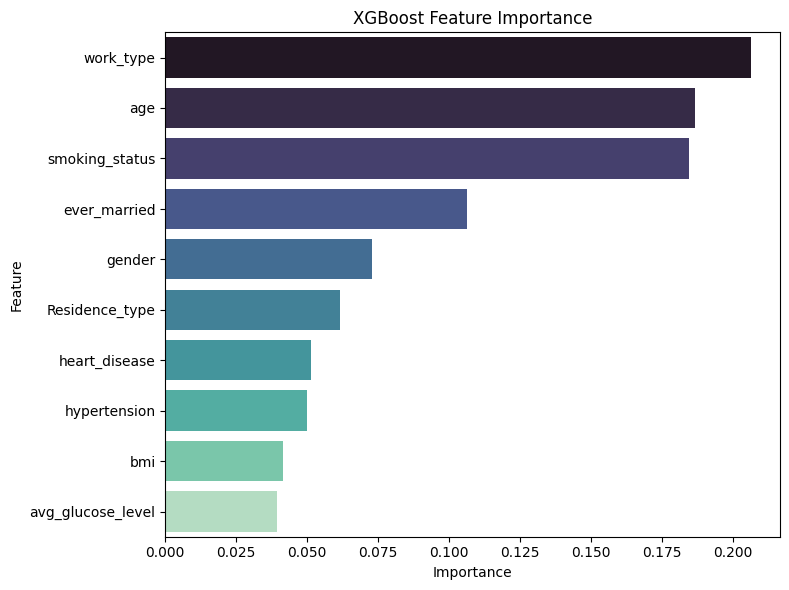

In [53]:
xgb_model = models["XGBoost"]
xgb_importances = xgb_model.feature_importances_

xgb_df = pd.DataFrame({'Feature': features, 'Importance': xgb_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(data=xgb_df, y='Feature', x='Importance', palette='mako')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()
